In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

In [3]:
Images = Path('../input/carrots-vs-rockets-image-classification/Images')

In [4]:
file_paths = list(Images.glob(r'**/*.jpg'))
labels = [path.parent.name for path in file_paths]
filepaths = pd.Series(file_paths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
image_df = pd.concat([filepaths, labels], axis=1)
image_df[0:5]

,Filepath,Label
0,../input/carrots-vs-rockets-image-classificati...,Rockets
1,../input/carrots-vs-rockets-image-classificati...,Rockets
2,../input/carrots-vs-rockets-image-classificati...,Rockets
3,../input/carrots-vs-rockets-image-classificati...,Rockets
4,../input/carrots-vs-rockets-image-classificati...,Rockets


In [5]:
# Shuffling it
image_df = image_df.sample(frac=1)
image_df.head(8)

,Filepath,Label
149,../input/carrots-vs-rockets-image-classificati...,Rockets
214,../input/carrots-vs-rockets-image-classificati...,Carrots
15,../input/carrots-vs-rockets-image-classificati...,Rockets
151,../input/carrots-vs-rockets-image-classificati...,Rockets
106,../input/carrots-vs-rockets-image-classificati...,Rockets
116,../input/carrots-vs-rockets-image-classificati...,Rockets
260,../input/carrots-vs-rockets-image-classificati...,Carrots
103,../input/carrots-vs-rockets-image-classificati...,Rockets


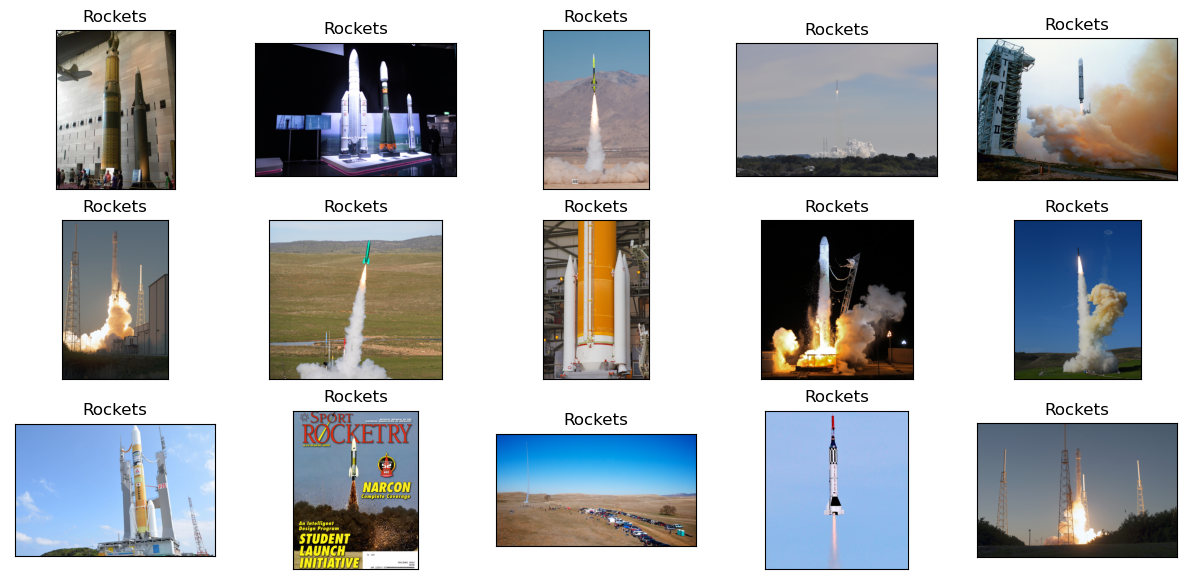

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.show()

In [7]:
train_df, test_df = train_test_split(image_df, test_size=0.1, shuffle=True, random_state=1)

In [8]:
train_df.shape

(275, 2)

In [9]:
train_df.head(8)

,Filepath,Label
208,../input/carrots-vs-rockets-image-classificati...,Carrots
100,../input/carrots-vs-rockets-image-classificati...,Rockets
130,../input/carrots-vs-rockets-image-classificati...,Rockets
41,../input/carrots-vs-rockets-image-classificati...,Rockets
175,../input/carrots-vs-rockets-image-classificati...,Carrots
127,../input/carrots-vs-rockets-image-classificati...,Rockets
223,../input/carrots-vs-rockets-image-classificati...,Carrots
288,../input/carrots-vs-rockets-image-classificati...,Carrots



Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing dat

In [10]:
# Playing with image by building up generators for changing in image states
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2, 
    zoom_range=0.2,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)
print(train_generator,test_generator,sep='\n')

In [11]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 220 validated image filenames belonging to 2 classes.
Found 55 validated image filenames belonging to 2 classes.
Found 31 validated image filenames belonging to 2 classes.


In [12]:
#viewing classes 
classes = train_images.class_indices
pd.DataFrame(data=classes,index=[0])

,Carrots,Rockets
0,0,1


In [13]:
# Input image -> conv with fliter 3x3, then maxpoling it, then another filter 3x3, another pooling, and another one, lastly dropout for overfitting and sigmoid to choose 
inputs = tf.keras.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(2,2)(x)
x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(2,2)(x)
x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu')(inputs)
x = tf.keras.layers.MaxPool2D(2,2)(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
outputs = tf.keras.layers.Dense(2, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [14]:
# Compilation
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [15]:
# Starting model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=25,
)

Epoch 1/25


2023-10-13 17:07:06.674114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


7/7 [==============================] - 24s 2s/step - loss: 33.8512 - accuracy: 0.6045 - val_loss: 12.9364 - val_accuracy: 0.5818
Epoch 2/25
7/7 [==============================] - 8s 1s/step - loss: 5.2267 - accuracy: 0.7545 - val_loss: 3.9779 - val_accuracy: 0.8364
Epoch 3/25
7/7 [==============================] - 9s 1s/step - loss: 2.7916 - accuracy: 0.8045 - val_loss: 1.6190 - val_accuracy: 0.8545
Epoch 4/25
7/7 [==============================] - 8s 1s/step - loss: 1.6853 - accuracy: 0.8318 - val_loss: 1.7942 - val_accuracy: 0.7636
Epoch 5/25
7/7 [==============================] - 8s 1s/step - loss: 1.3813 - accuracy: 0.8364 - val_loss: 0.7297 - val_accuracy: 0.8182
Epoch 6/25
7/7 [==============================] - 9s 1s/step - loss: 0.5972 - accuracy: 0.8545 - val_loss: 0.7216 - val_accuracy: 0.7636
Epoch 7/25
7/7 [==============================] - 9s 1s/step - loss: 0.2820 - accuracy: 0.8955 - val_loss: 0.4427 - val_accuracy: 0.8727
Epoch 8/25
7/7 [==============================] -

In [16]:
#Evaluate the model
results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.15040
Test Accuracy: 93.55%


In [17]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = {0:'Carrots',1:'Rockets'}
pred = [labels[k] for k in pred]
# Display the result
print(f'The first 5 predictions: {pred[:5]}')

1/1 [==============================] - 1s 1s/step
The first 5 predictions: ['Carrots', 'Rockets', 'Carrots', 'Carrots', 'Carrots']


In [18]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     Carrots       0.89      1.00      0.94        17
     Rockets       1.00      0.86      0.92        14

    accuracy                           0.94        31
   macro avg       0.95      0.93      0.93        31
weighted avg       0.94      0.94      0.93        31



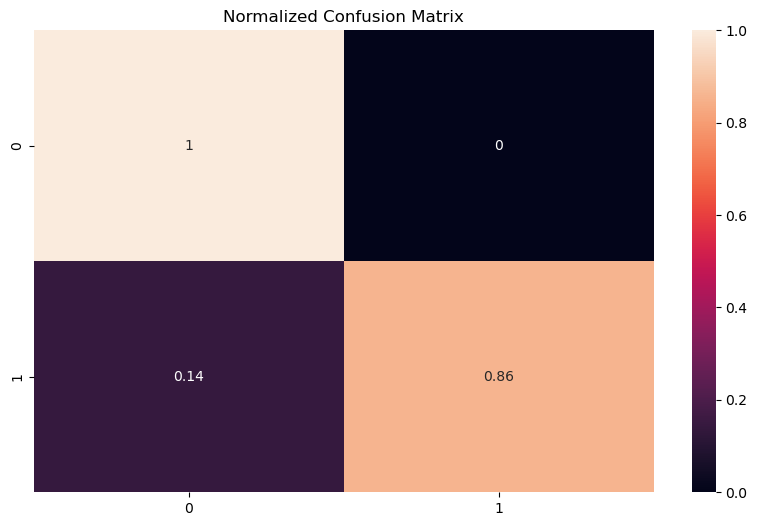

In [19]:
# Let's know percent of negative or positive for data
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True)
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
# For Flutter Model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)